In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import glob
from scipy.signal import welch, butter, filtfilt
from scipy.signal import detrend
from scipy.signal import spectrogram
from scipy.stats import zscore

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Dataset with only Turn event
df_1 = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/04e10e0797.csv")

# Dataset with Turn and Walking event
df_2 = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/146bd622af.csv")

# Dataset with Turn and StartHesitation event
df_3 = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/166bc81085.csv")

In [3]:
print(df_1.head())
print(df_2.head())
print(df_3.head())

   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking
0     0 -9.330816  0.649608 -2.219920                0     0        0
1     1 -9.332794  0.631624 -2.195057                0     0        0
2     2 -9.330623  0.636067 -2.176996                0     0        0
3     3 -9.330805  0.647316 -2.179266                0     0        0
4     4 -9.331018  0.674393 -2.215282                0     0        0
   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking
0     0 -9.469575  0.803600 -1.414898                0     0        0
1     1 -9.467594  0.800920 -1.408512                0     0        0
2     2 -9.473403  0.799942 -1.407336                0     0        0
3     3 -9.467359  0.805807 -1.410385                0     0        0
4     4 -9.476454  0.810452 -1.410384                0     0        0
   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking
0     0 -9.477831 -1.041629 -1.081219                0     0        0
1     1 -9.470954 -1

In [4]:
def basic_stats(df):
    stats = {}
    for col in ["AccV", "AccML", "AccAP"]:
        stats[col] = {
            "mean": df[col].mean(),
            "std": df[col].std(),
            "min": df[col].min(),
            "max": df[col].max(),
            "median": df[col].median(),
            "q25": df[col].quantile(0.25),
            "q75": df[col].quantile(0.75),
        }
    return pd.DataFrame(stats)

In [5]:
overall_stats_1 = basic_stats(df_1)
print("Overall Stats in df_1:\n", overall_stats_1)

overall_stats_2 = basic_stats(df_2)
print("Overall Stats in df_2:\n", overall_stats_2)

overall_stats_3 = basic_stats(df_3)
print("Overall Stats in df_3:\n", overall_stats_3)

Overall Stats in df_1:
              AccV      AccML      AccAP
mean    -8.889149  -0.199604   3.695859
std      0.708428   0.919776   1.382500
min    -18.623516  -6.278487  -7.063795
max     -4.126374  10.029988  14.523853
median  -8.899208  -0.111615   3.810496
q25     -9.304930  -0.819081   3.563448
q75     -8.494233   0.483060   4.146544
Overall Stats in df_2:
              AccV     AccML      AccAP
mean    -9.559733  0.211931   1.042616
std      0.679613  0.794549   0.848803
min    -21.659887 -2.813945  -3.763821
max     -6.318983  4.734698  13.070144
median  -9.545045  0.207859   1.063720
q25     -9.702500 -0.192107   0.717624
q75     -9.358362  0.655242   1.420827
Overall Stats in df_3:
              AccV     AccML     AccAP
mean    -9.414298  0.362835  1.274337
std      0.903996  1.257047  1.843788
min    -15.684572 -6.376880 -4.105980
max     -5.667476  7.123671  5.651088
median  -9.440047  0.428729  1.617088
q25     -9.714201 -0.462071  0.484814
q75     -8.916375  1.052110  2

The function below generates line plots for each dataset, showing the accelerometer signals over time. If FoG events are present, they are highlighted as shaded rectangles in different colors, marking the exact time where the events occur.

In [6]:
def plot_fog_events_overlay(df, title):
    """
    Plot accelerometer signals with FoG events shaded directly on the same graph.
    """
    # Convert timestamps to seconds
    df["Time_sec"] = df["Time"] / 128.0  
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot all 3 accelerometer signals
    ax.plot(df["Time_sec"], df["AccV"], label="AccV (Vertical)", alpha=0.7)
    ax.plot(df["Time_sec"], df["AccML"], label="AccML (Medio-Lateral)", alpha=0.7)
    ax.plot(df["Time_sec"], df["AccAP"], label="AccAP (Antero-Posterior)", alpha=0.7)
    
    # Shade event regions
    colors = {
        "Turn": "green",
        "Walking": "blue",
        "StartHesitation": "red"
    }
    
    for event, color in colors.items():
        if event in df.columns:
            # Find contiguous segments where event == 1
            in_event = False
            start_time = None
            for t, val in zip(df["Time_sec"], df[event]):
                if val == 1 and not in_event:
                    in_event = True
                    start_time = t
                elif val == 0 and in_event:
                    in_event = False
                    ax.axvspan(start_time, t, color=color, alpha=0.2, label=event)
            # If event lasts until the end
            if in_event:
                ax.axvspan(start_time, df["Time_sec"].iloc[-1], color=color, alpha=0.2, label=event)
    
    ax.set_title(title)
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Acceleration (m/s^2)")
    ax.legend()
    plt.show()

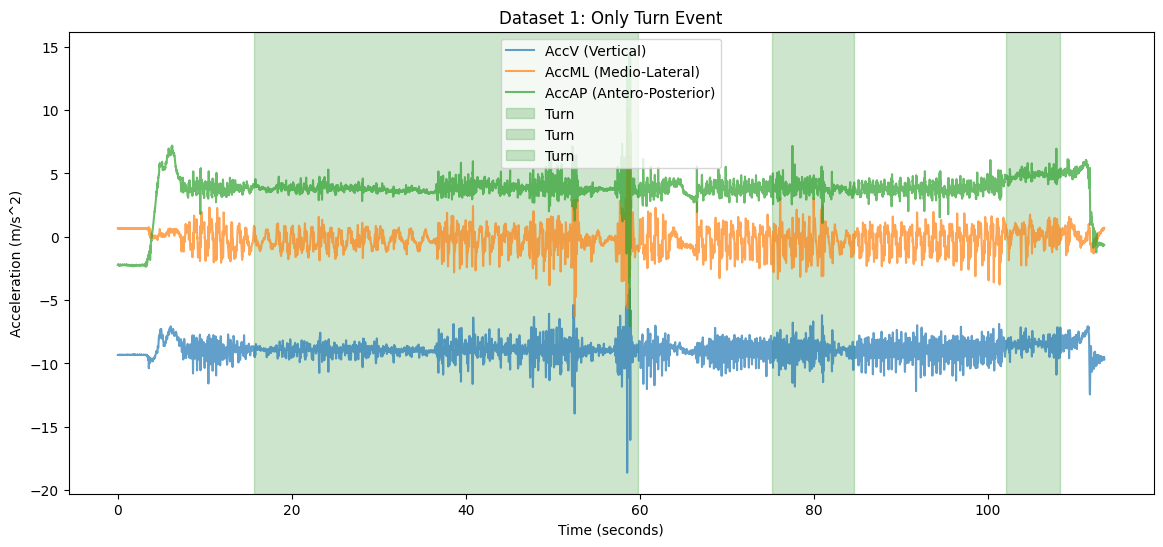

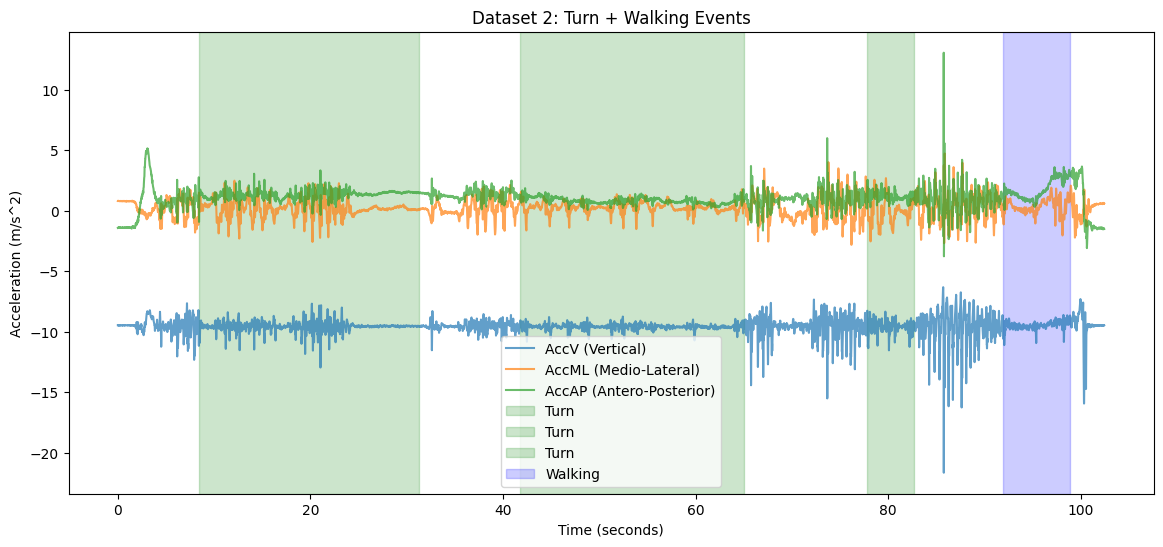

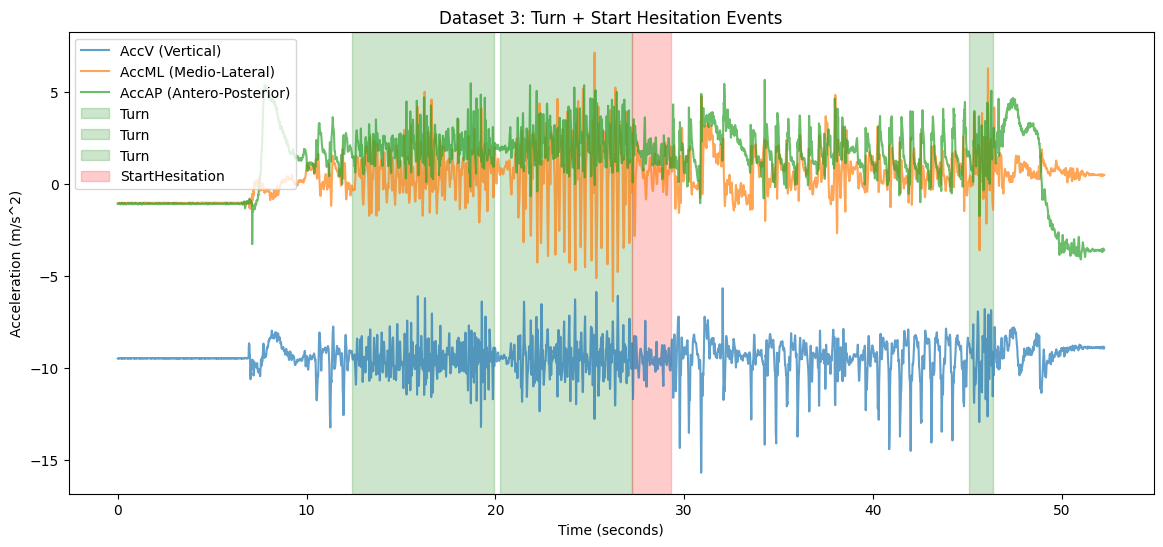

In [7]:
# Plotting all the datasets
plot_fog_events_overlay(df_1, "Dataset 1: Only Turn Event")
plot_fog_events_overlay(df_2, "Dataset 2: Turn + Walking Events")
plot_fog_events_overlay(df_3, "Dataset 3: Turn + Start Hesitation Events")

Dataset 1: Only Turn Event
In this first graph, the accelerometer data looks pretty stable overall, but once the FoG event starts, you can see the signals shift a bit, especially on the side-to-side axis. The shaded areas mark exactly when the event happens, and that’s when the data looks less smooth. It shows how the turn introduces some instability in the motion.

Dataset 2: Turn + Walking Events
In the second graph, the data has a steady rhythm that matches walking. What stands out is that during the FoG events, that rhythm breaks down. The signal doesn’t keep the same regular pattern anymore, and you can see sudden changes in the wave shapes. The shaded areas makes it clear where the events happen, and you can tell those moments line up with interruptions in the walking pattern.

Dataset 3: Turn + Start Hesitation Events
The third graph looks noisier than the others, but you can still spot the FoG events when you check the markers. At those points, the accelerations either slow down, bundle up, or don’t increase the way they normally should. That matches the hesitation before starting movement. Even with all the noise, the markers help show exactly when the hesitation happens.

In [8]:
def accel_magnitude(df):
    return np.sqrt(df['AccV']**2 + df['AccML']**2 + df['AccAP']**2)

In [9]:
# Function to plot magnitude with shaded event regions
def plot_magnitude_with_events(df, title):
    time = df["Time"].values / 128  # Convert to seconds
    magnitude = accel_magnitude(df)

    plt.figure(figsize=(12, 5))
    plt.plot(time, magnitude, label="Acceleration Magnitude", color="blue", alpha=0.7)

    # Shade event regions
    for event, color in zip(["StartHesitation", "Turn", "Walking"],
                            ["red", "green", "blue"]):
        if event in df.columns:
            in_event = False
            start_time = None
            for i, val in enumerate(df[event].values):
                if val == 1 and not in_event:
                    in_event = True
                    start_time = time[i]
                elif val == 0 and in_event:
                    in_event = False
                    plt.axvspan(start_time, time[i], color=color, alpha=0.3, label=event)
            # If event goes until the end of the recording
            if in_event:
                plt.axvspan(start_time, time[-1], color=color, alpha=0.3, label=event)

    # Make legend unique (avoid duplicates when multiple spans exist)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel("Time (seconds)")
    plt.ylabel("Magnitude")
    plt.title(title)
    plt.show()

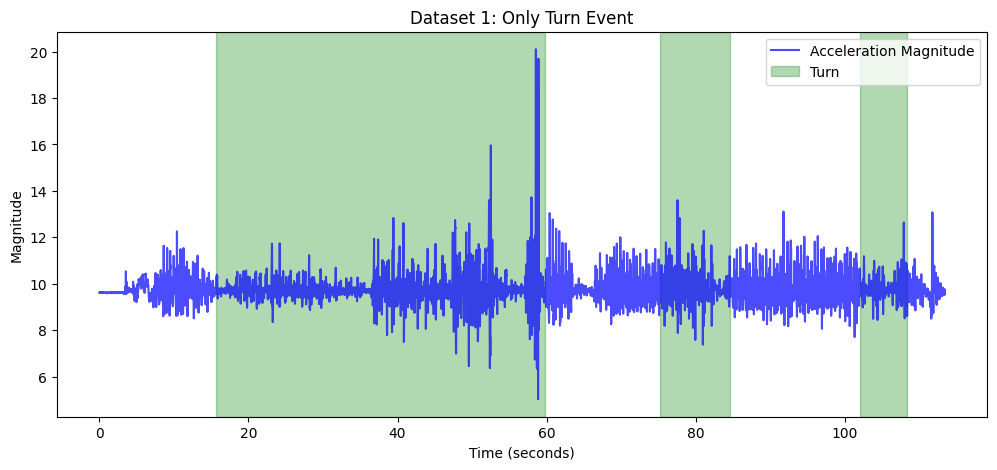

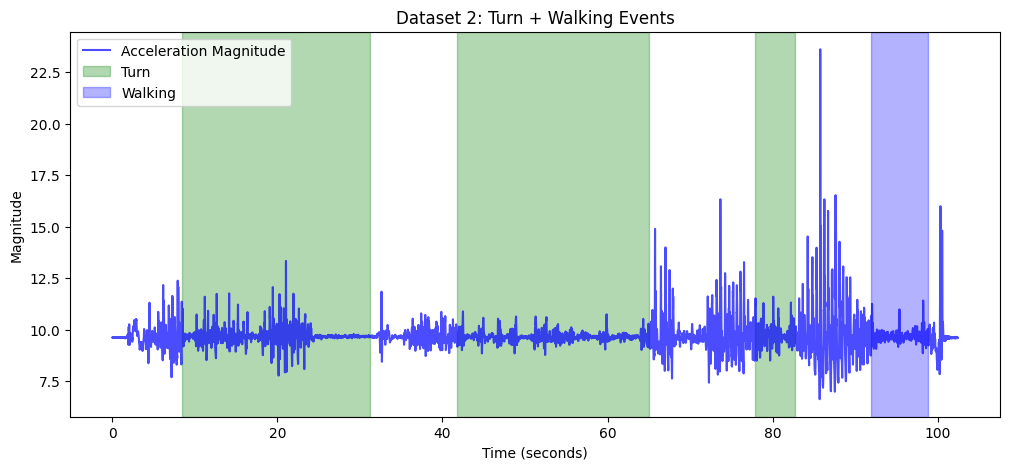

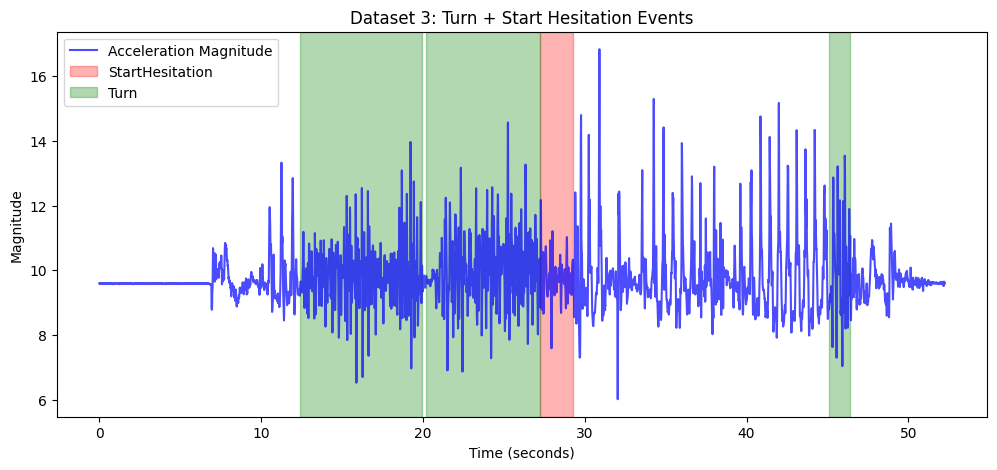

In [10]:
plot_magnitude_with_events(df_1, "Dataset 1: Only Turn Event")
plot_magnitude_with_events(df_2, "Dataset 2: Turn + Walking Events")
plot_magnitude_with_events(df_3, "Dataset 3: Turn + Start Hesitation Events")

In [11]:
def butter_lowpass_filter(signal, cutoff=15, fs=128, order=2):
    nyquist = 0.5 * fs
    norm_cutoff = cutoff / nyquist
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

In [12]:
def sliding_windows(n, win, hop):
    for start in range(0, n - win + 1, hop):
        yield start, start + win

In [13]:
def plot_individual_window_ffts(
    df, fs=128, window_sec=3.0, overlap=0.5,
    fog_fraction_threshold=0.5, movement_std_thresh=0.05,
    freq_limit=15
):
    """
    Plots the FFT for every 3-second (default) window.
    Each window is plotted separately with a label:
        - Walking (non-FOG)
        - FoG
    """
    
    # 1. Combine and filter signal
    x = accel_magnitude(df)
    x = butter_lowpass_filter(x, cutoff=15, fs=fs)
    x = x - np.mean(x)

    # FoG mask
    event_cols = [c for c in ['StartHesitation', 'Turn', 'Walking'] if c in df.columns]
    fog_mask = (df[event_cols].sum(axis=1) > 0).values

    # 2. Windowing params
    win = int(window_sec * fs)
    hop = int(win * (1 - overlap))
    N = len(x)

    window_num = 1

    # 3. Loop through windows and plot
    for s, e in sliding_windows(N, win, hop):
        seg = x[s:e]
        fog_frac = fog_mask[s:e].mean()
        moving = np.std(seg) >= movement_std_thresh

        # Determine label
        if fog_frac >= fog_fraction_threshold:
            label = "FoG"
        elif fog_frac == 0 and moving:
            label = "Walking"
        else:
            label = "Inactive / Low Movement"

        # FFT
        seg = seg - np.mean(seg)
        fft_vals = np.fft.rfft(seg)
        freqs = np.fft.rfftfreq(len(seg), d=1/fs)
        mag = np.abs(fft_vals) / len(seg)

        # limit to 0–freq_limit Hz
        m = freqs <= freq_limit
        freqs = freqs[m]
        mag = mag[m]

        # Plot individual FFT window
        plt.figure(figsize=(8, 4))
        plt.plot(freqs, mag, linewidth=2)
        plt.title(
            f"Window {window_num} ({s/fs:.1f}s–{e/fs:.1f}s) – {label}"
        )
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude")
        plt.grid(True, alpha=0.3)
        plt.ylim(0, max(mag) * 1.2)
        plt.show()

        window_num += 1

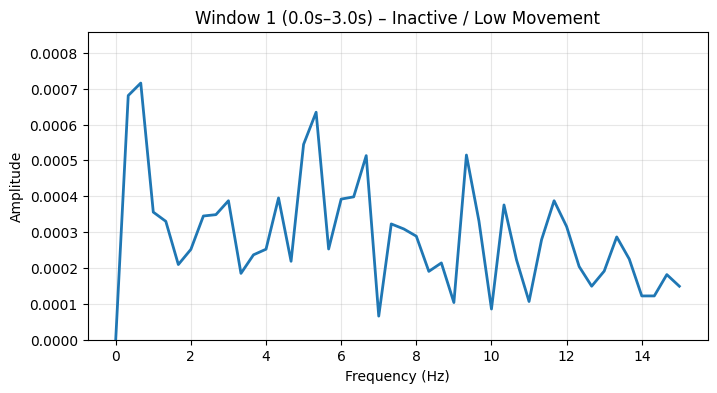

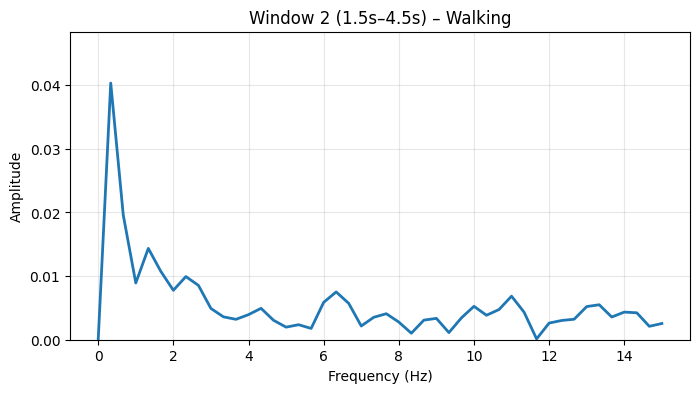

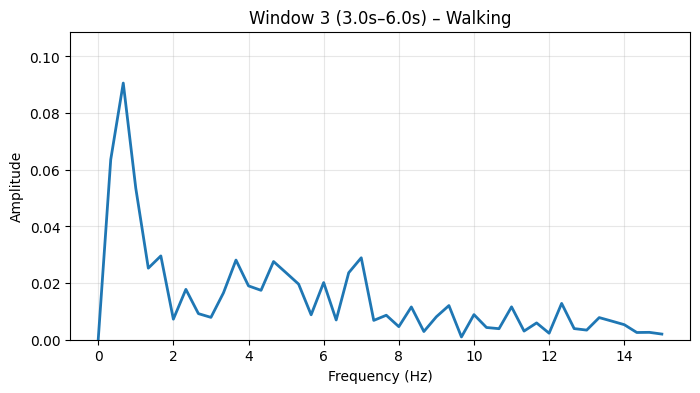

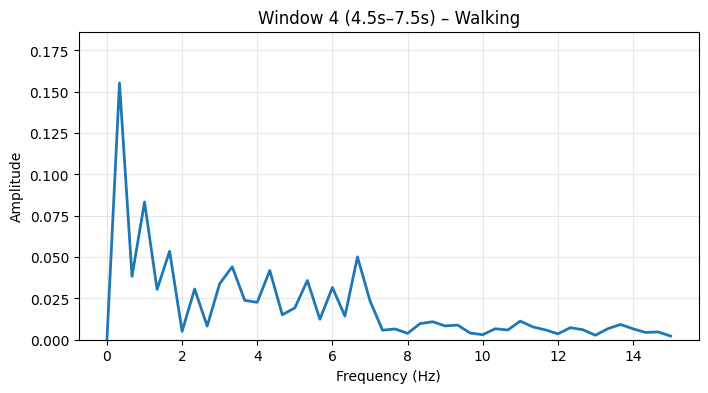

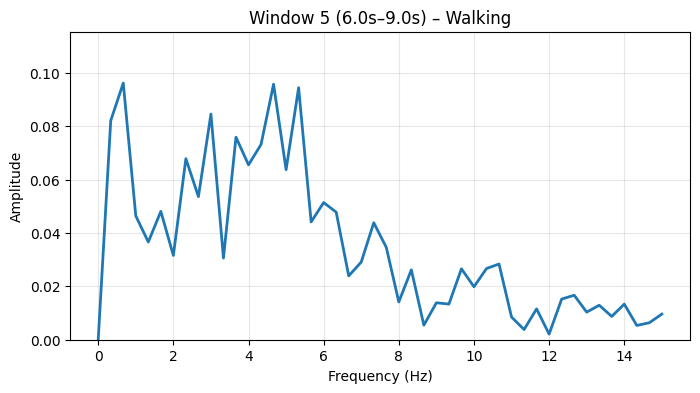

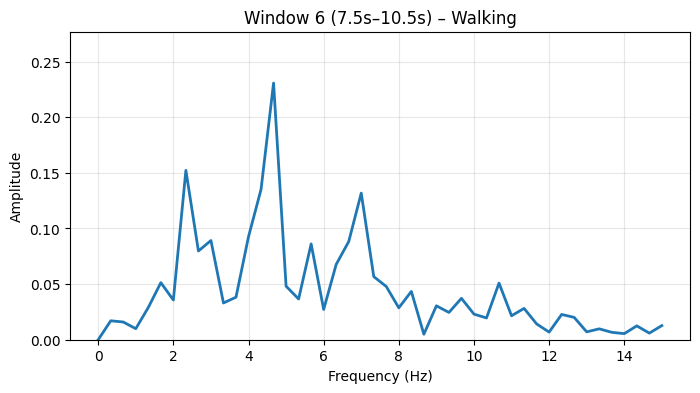

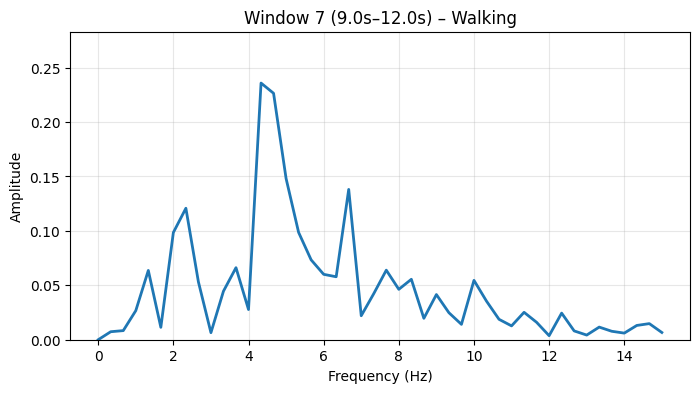

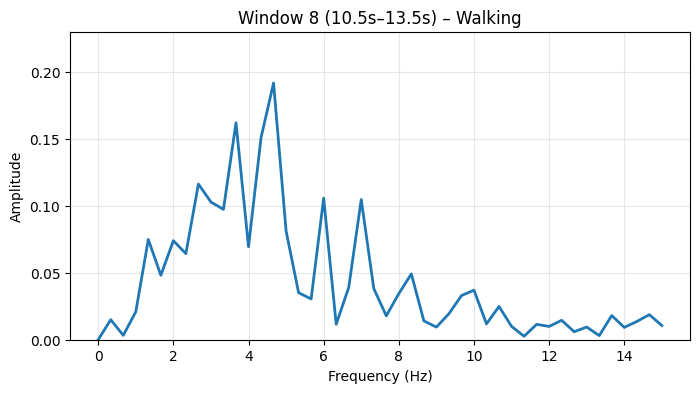

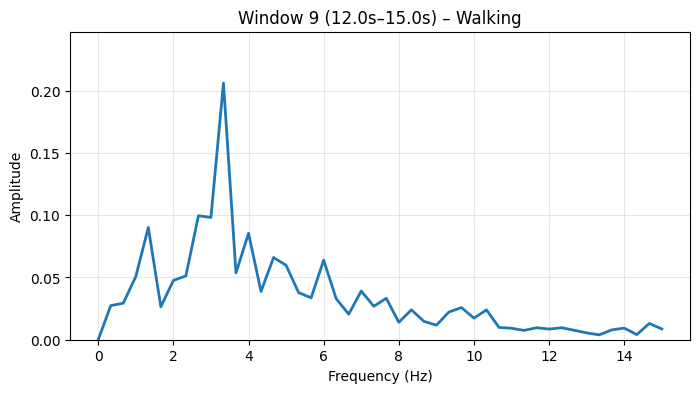

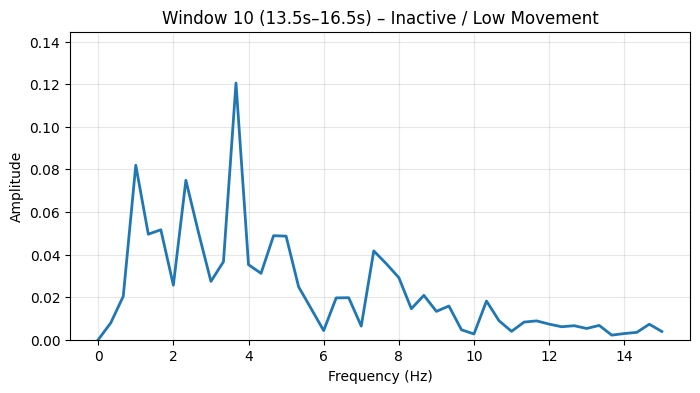

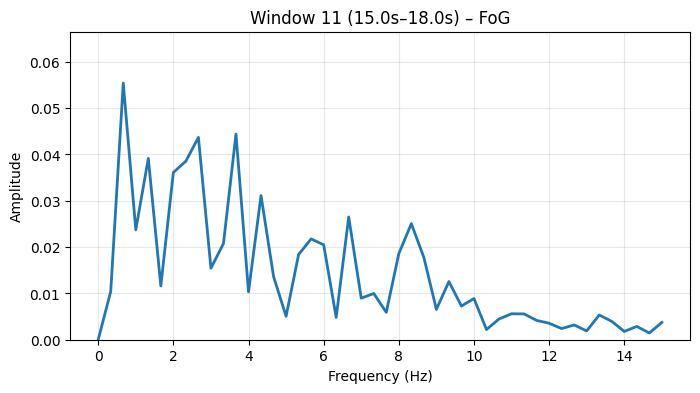

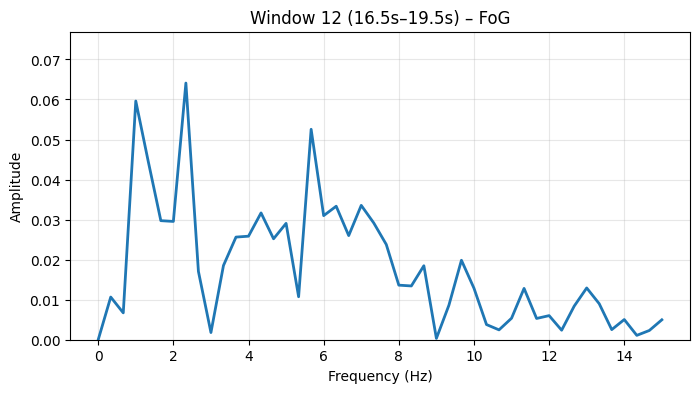

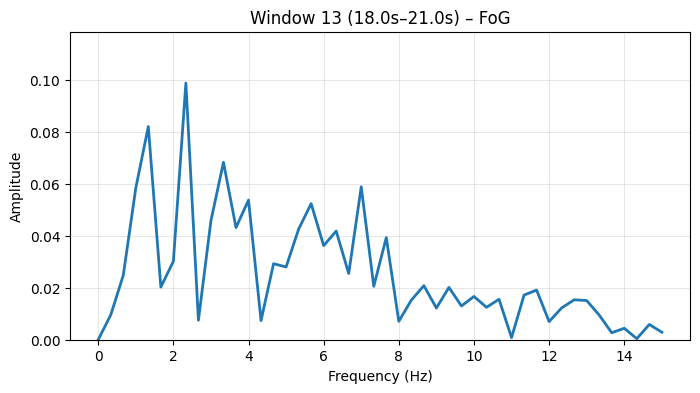

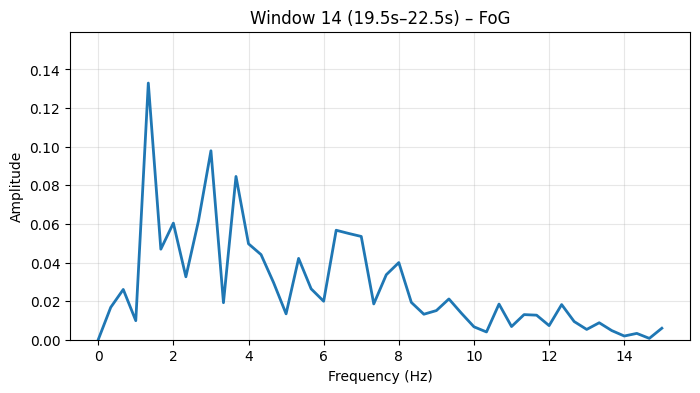

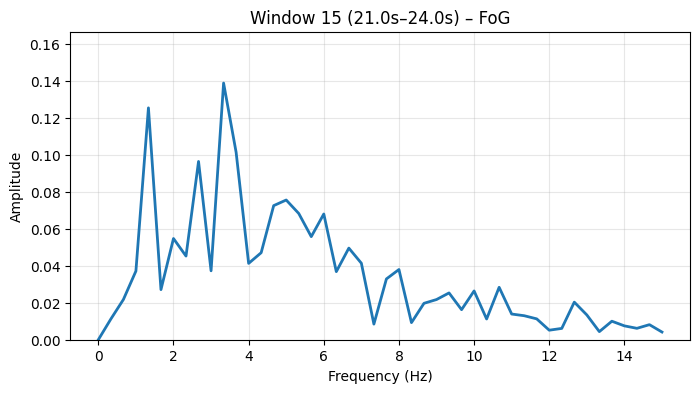

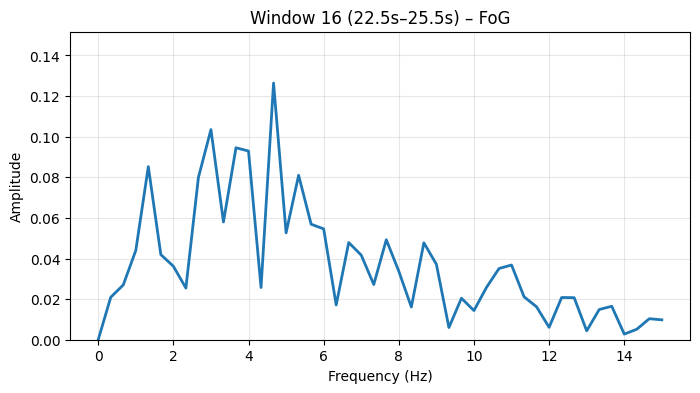

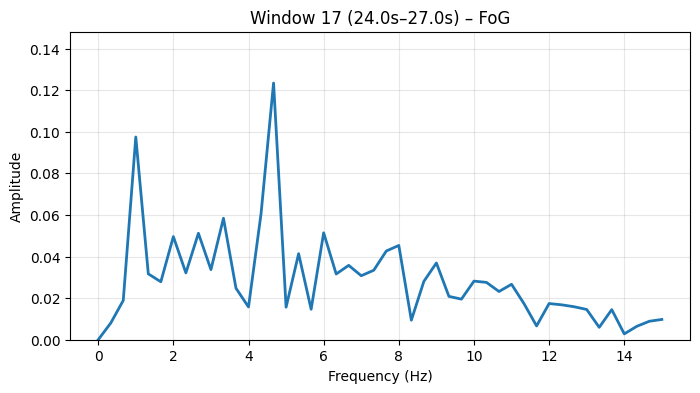

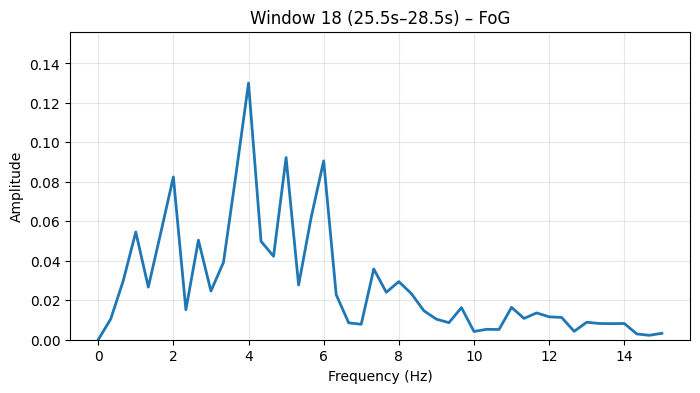

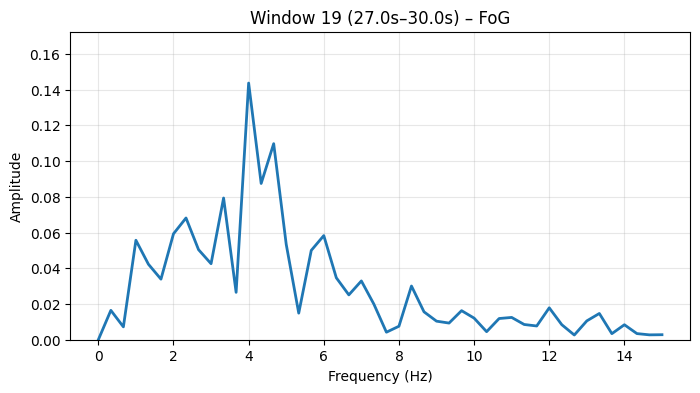

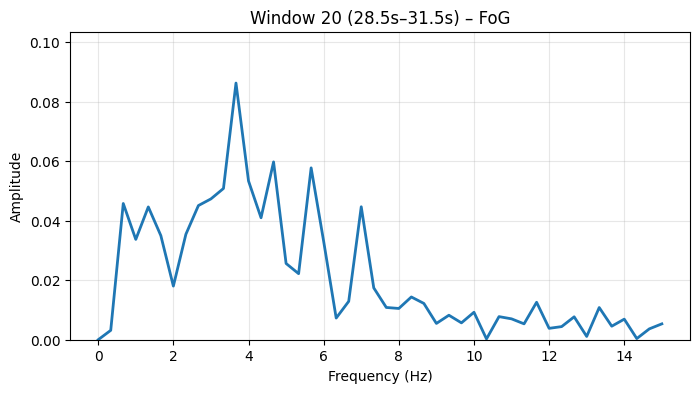

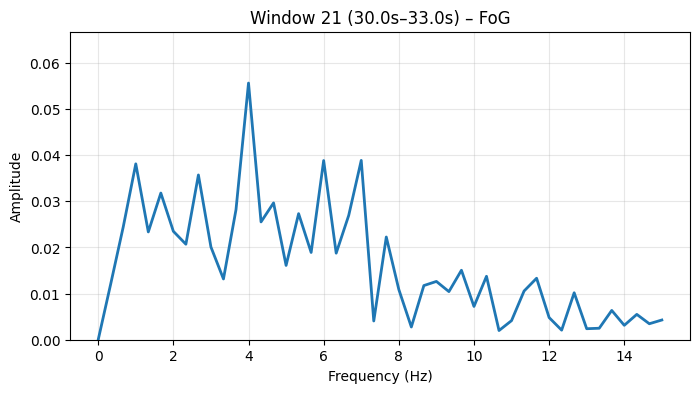

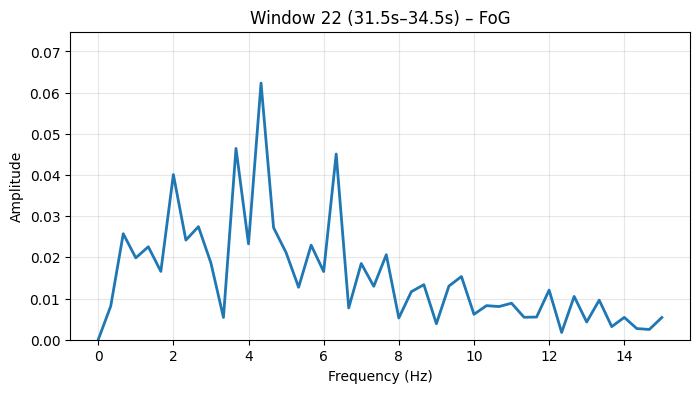

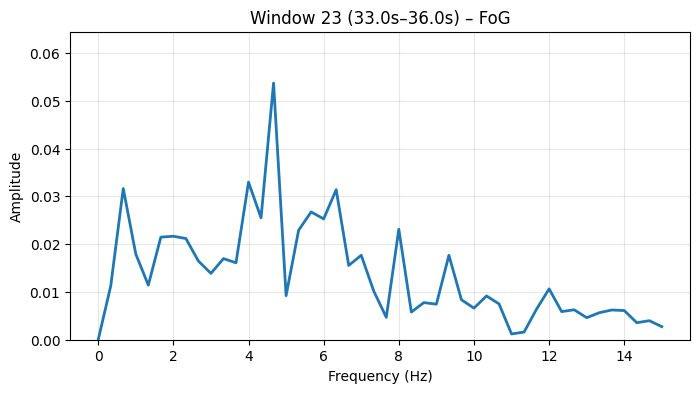

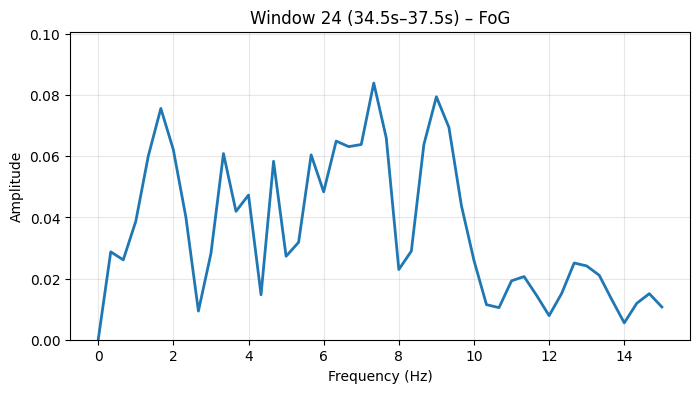

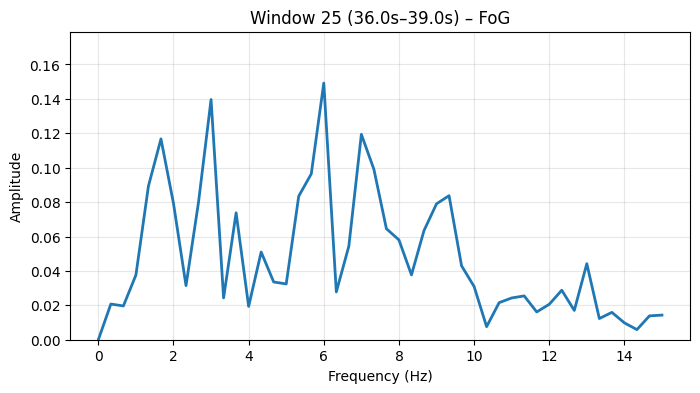

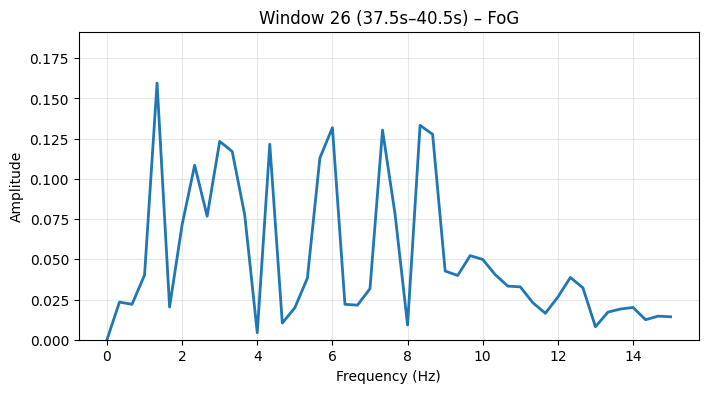

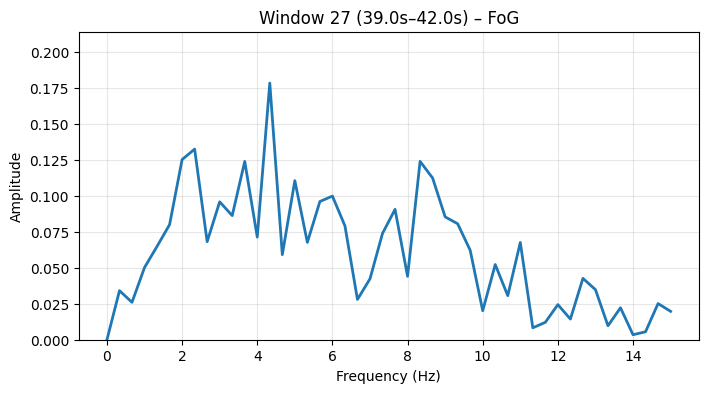

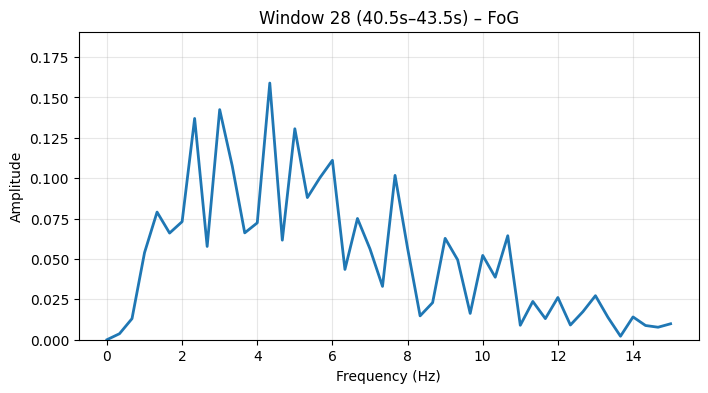

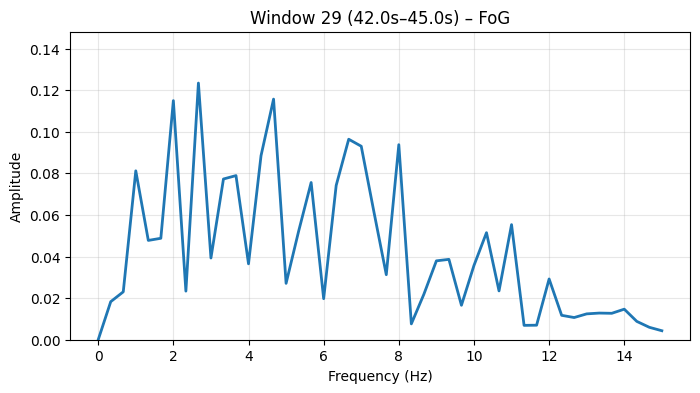

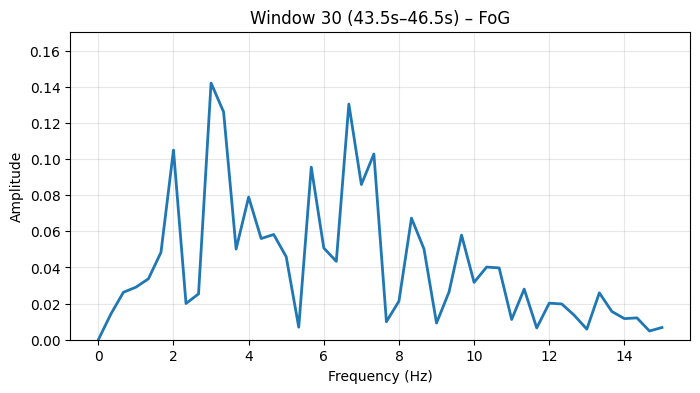

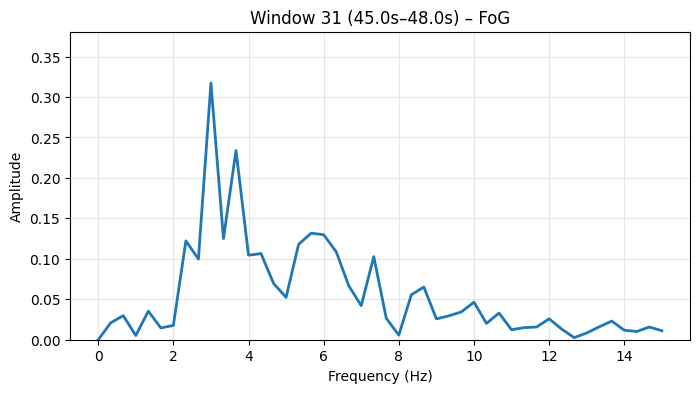

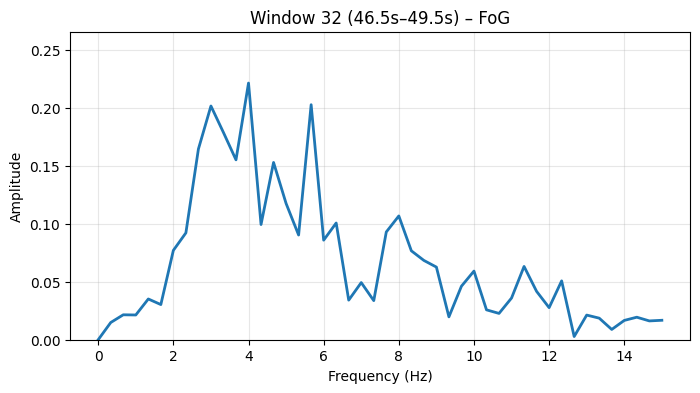

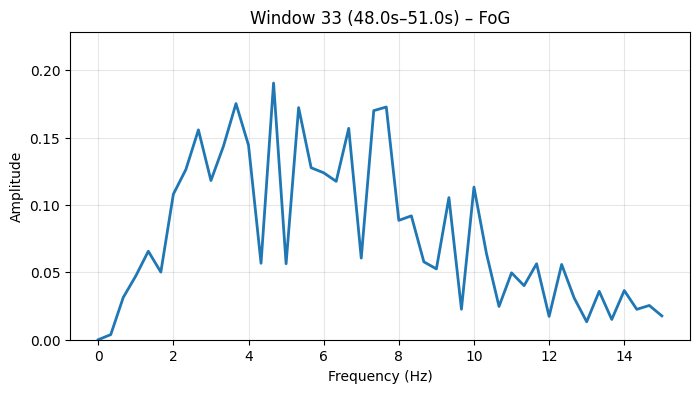

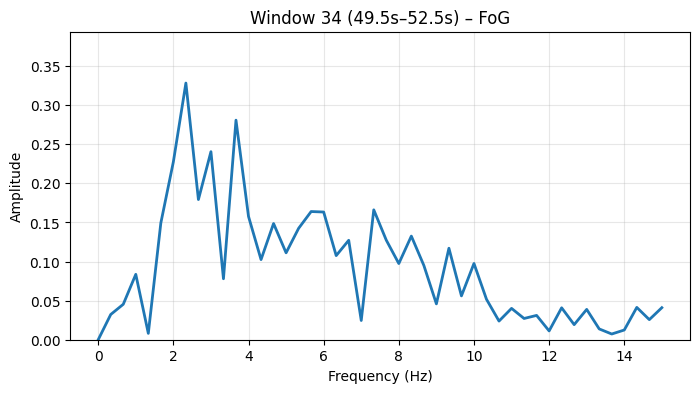

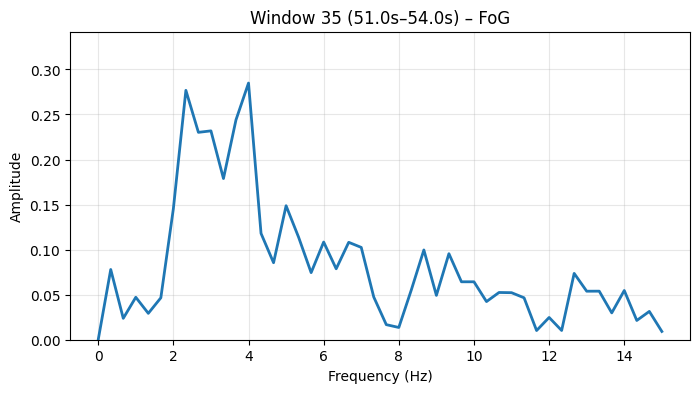

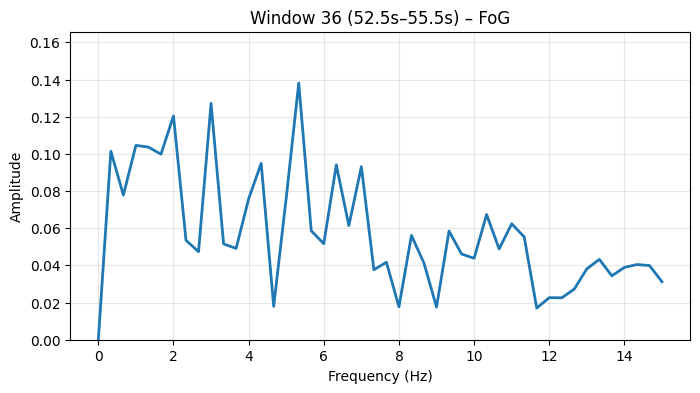

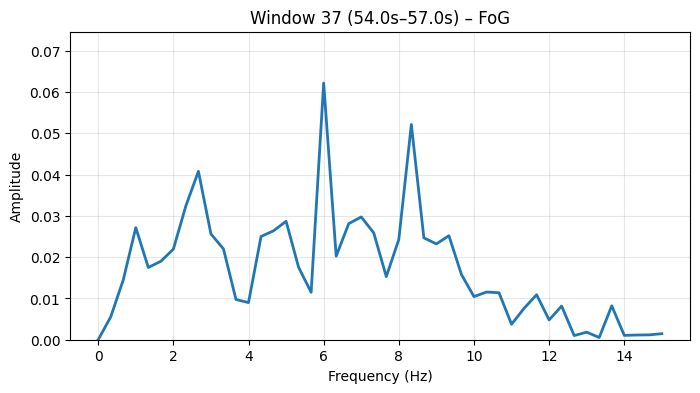

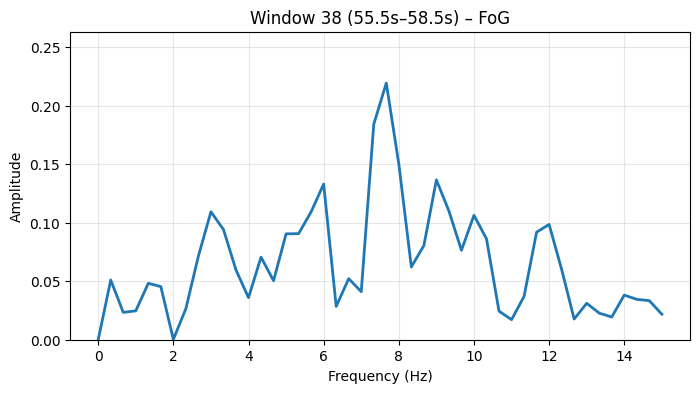

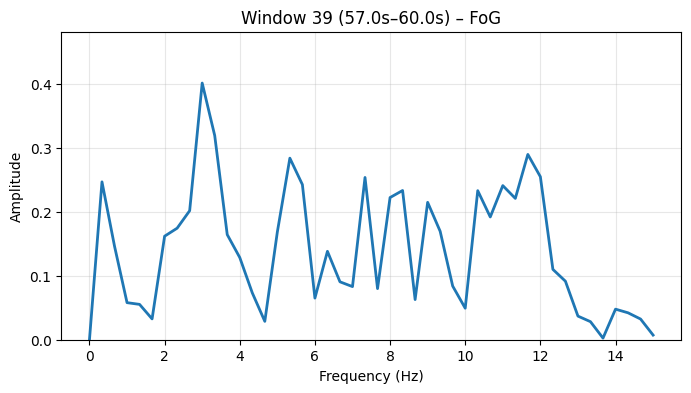

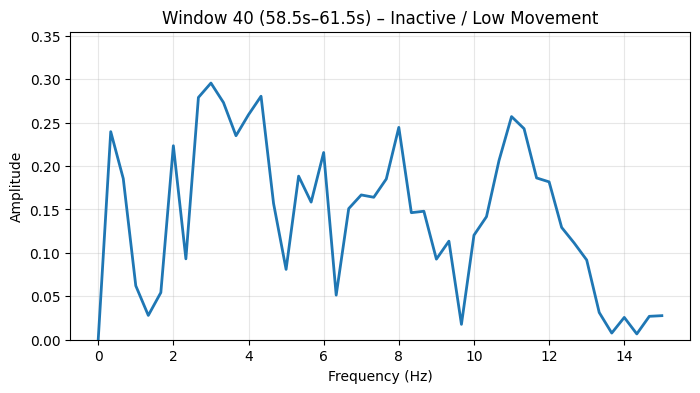

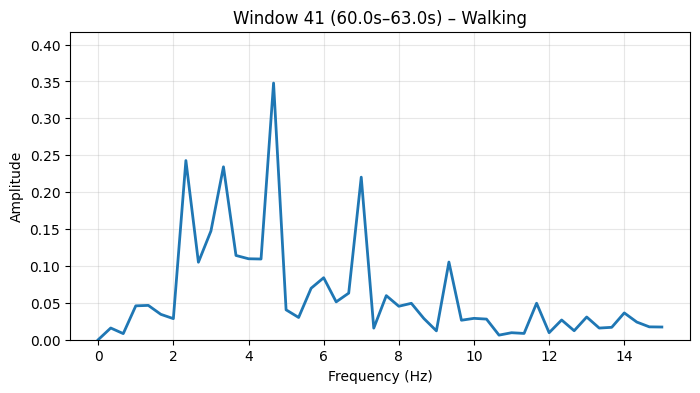

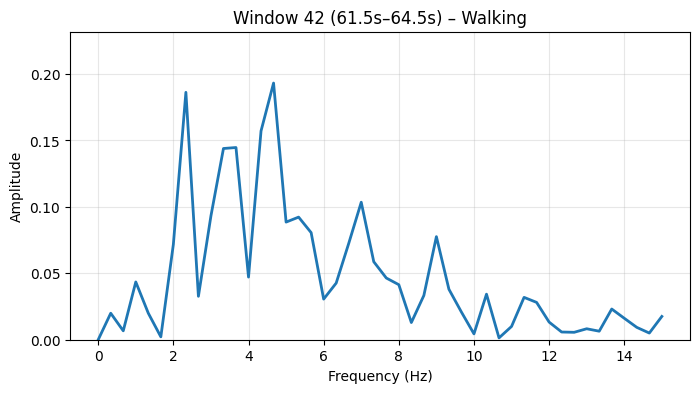

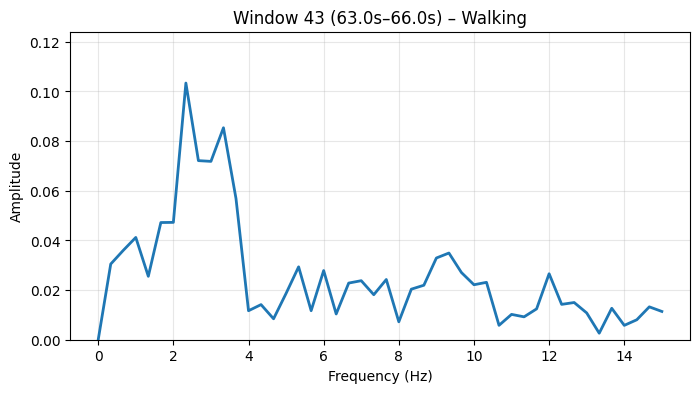

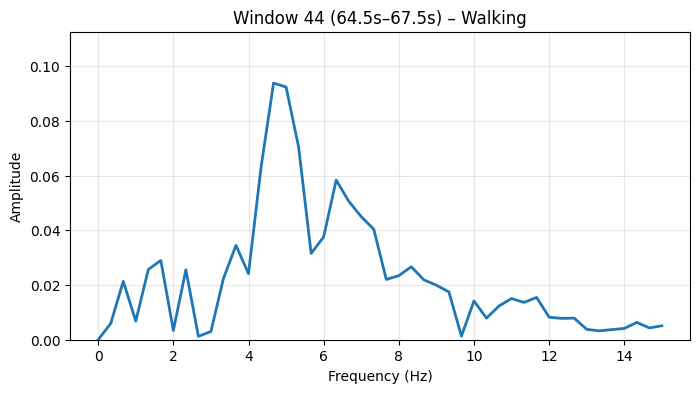

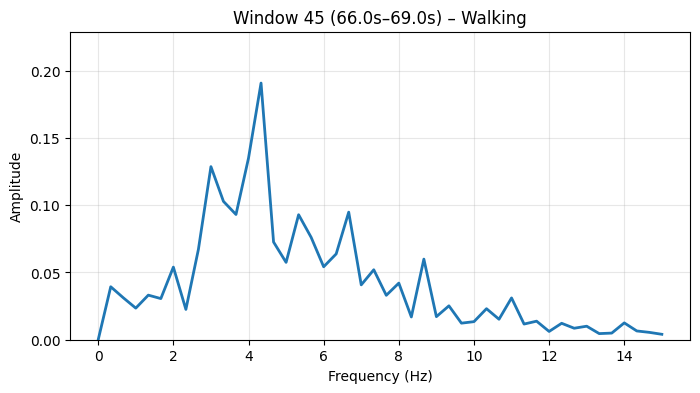

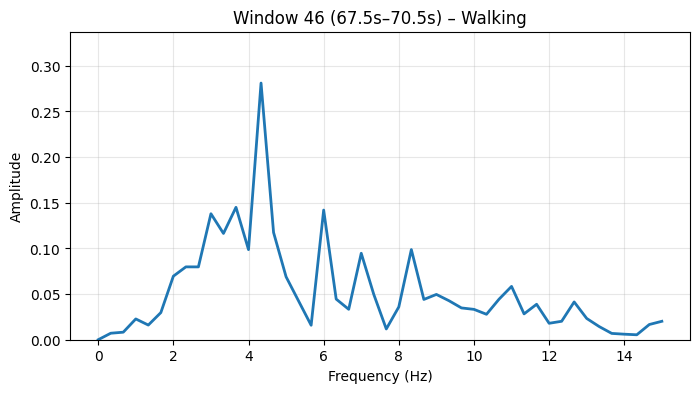

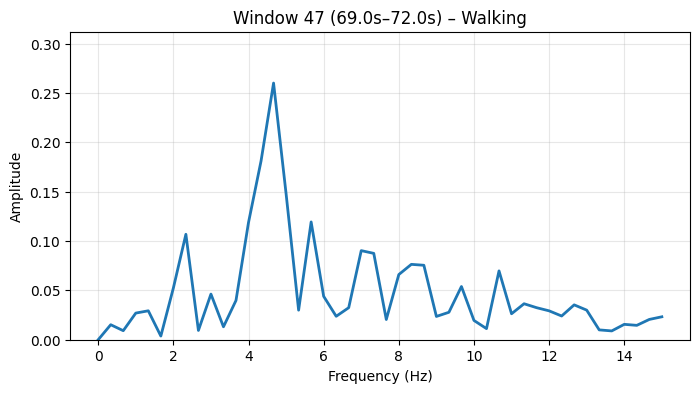

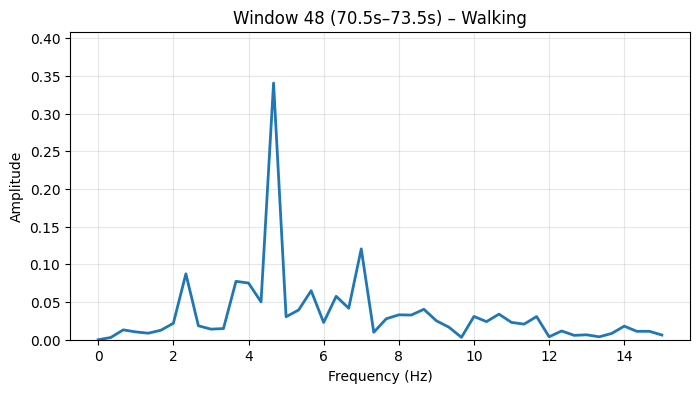

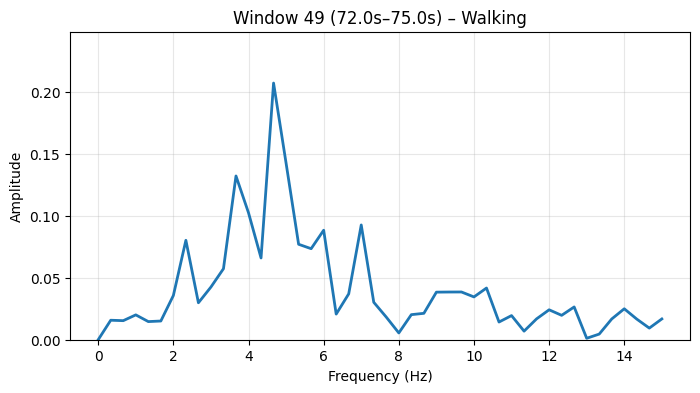

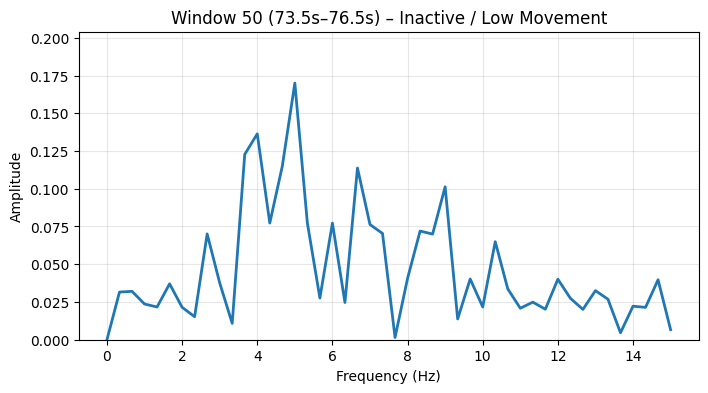

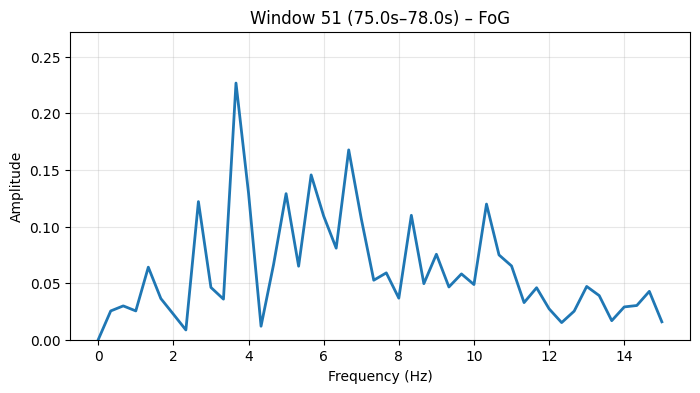

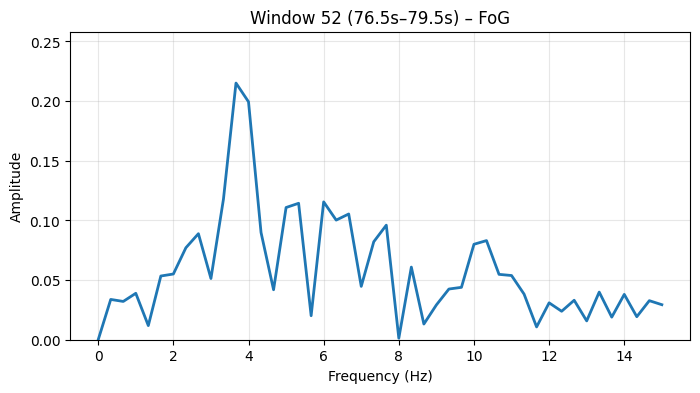

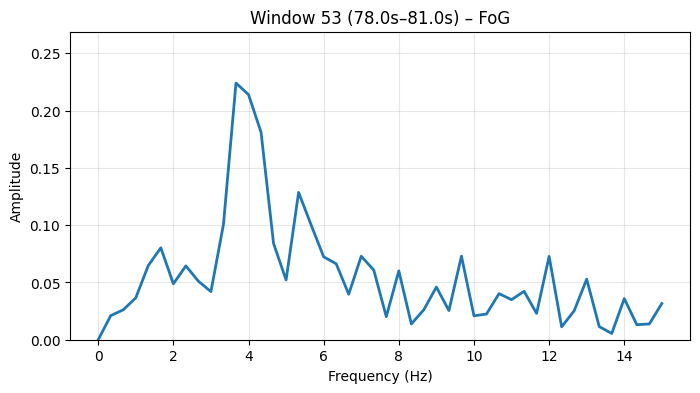

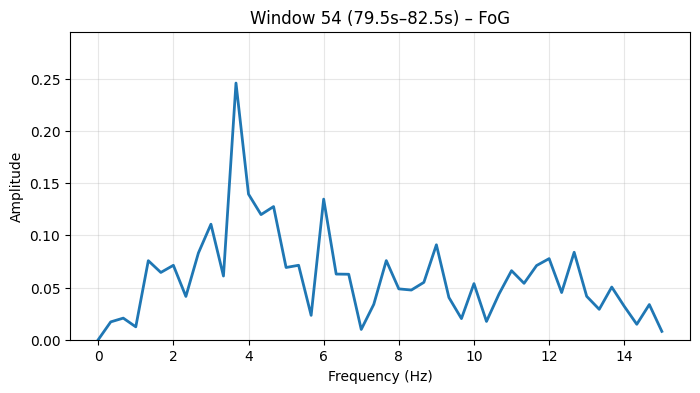

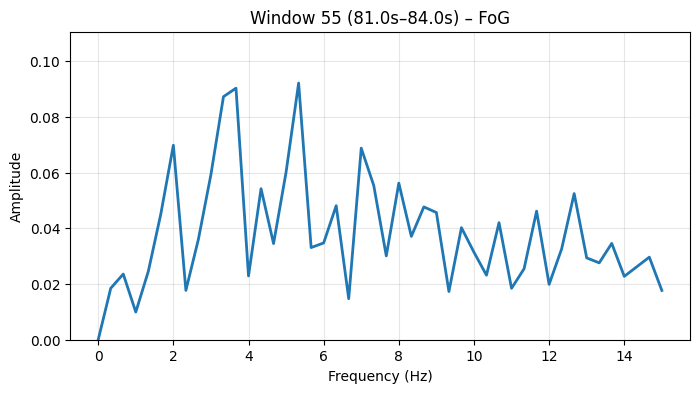

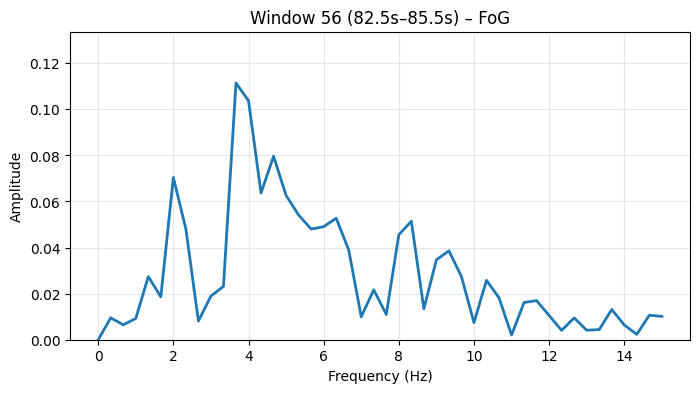

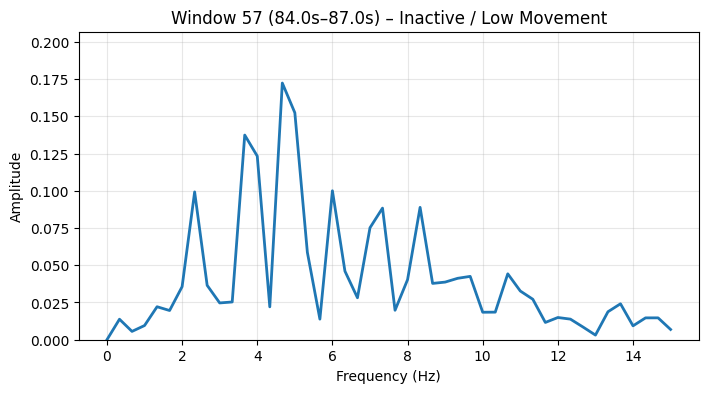

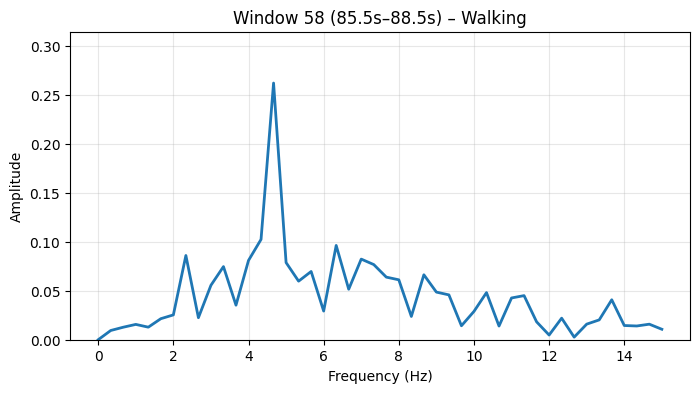

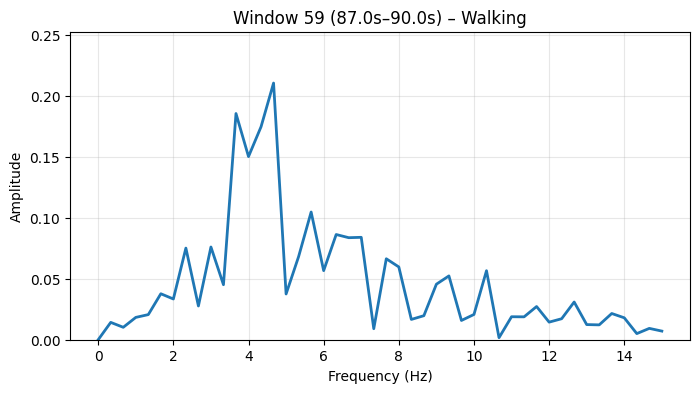

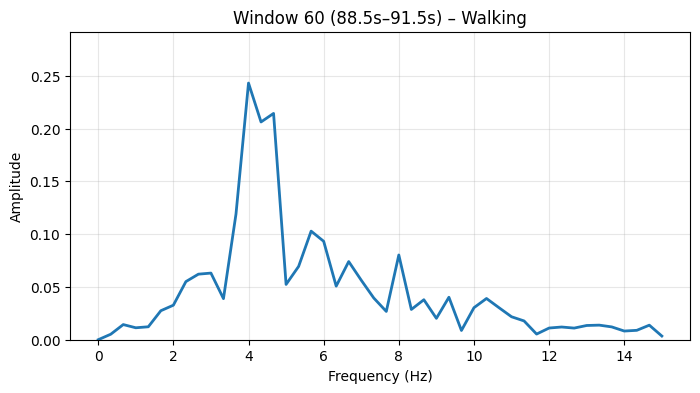

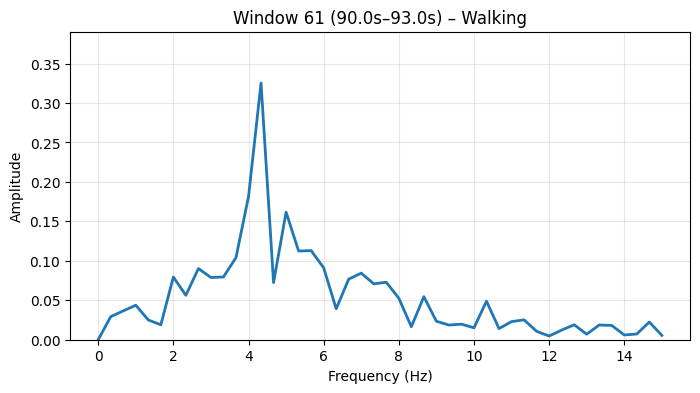

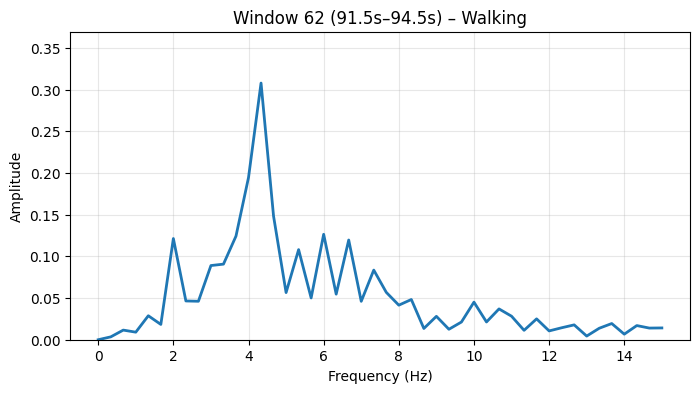

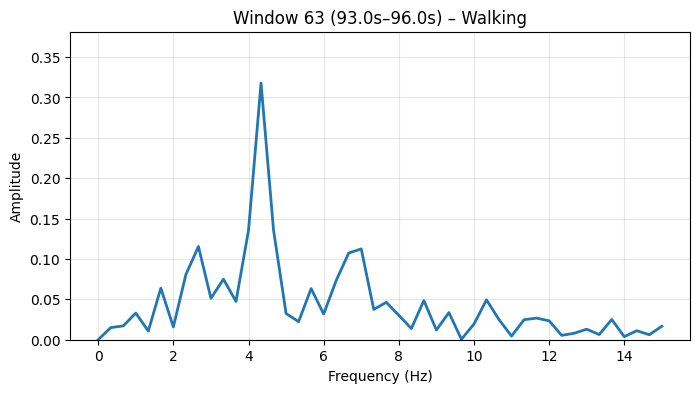

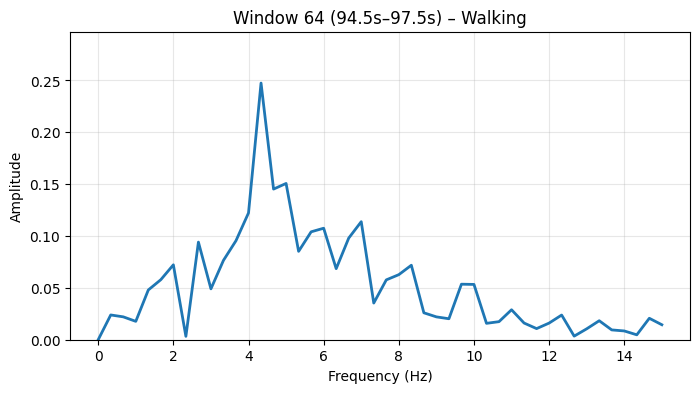

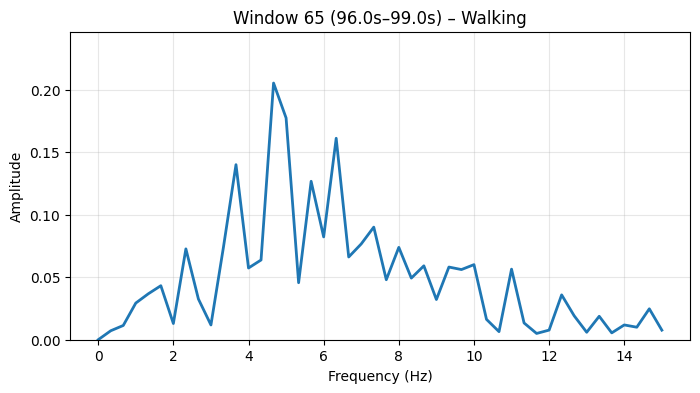

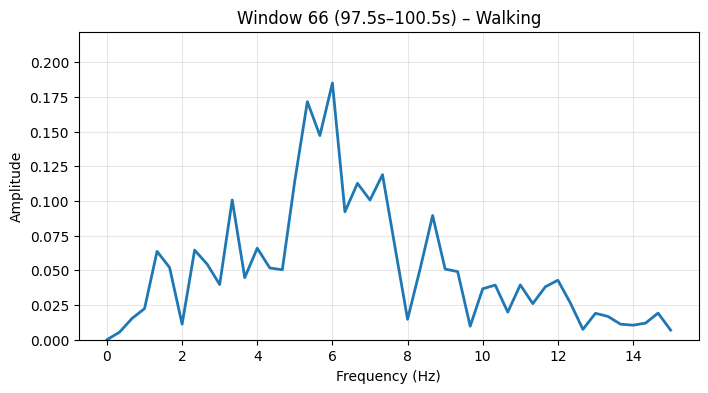

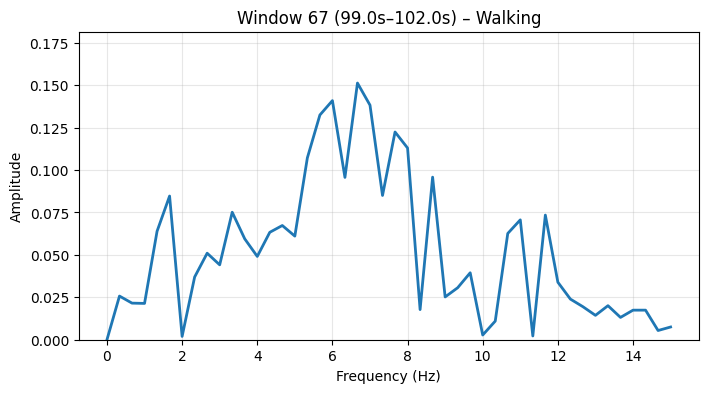

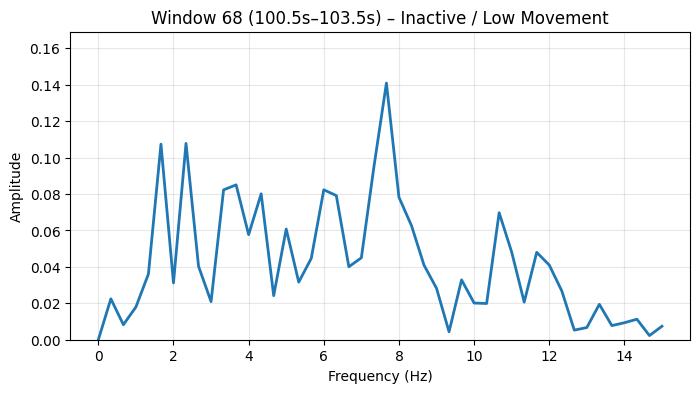

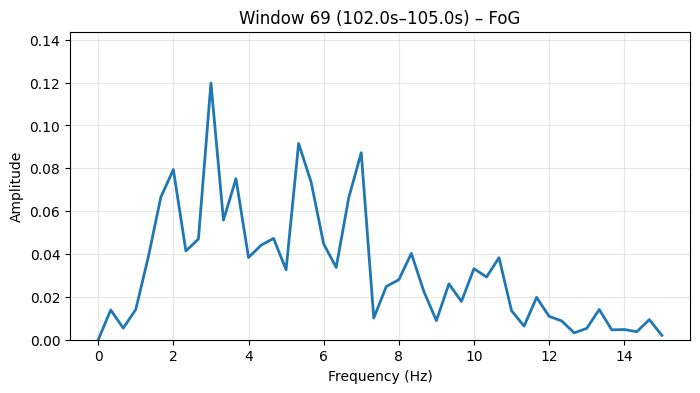

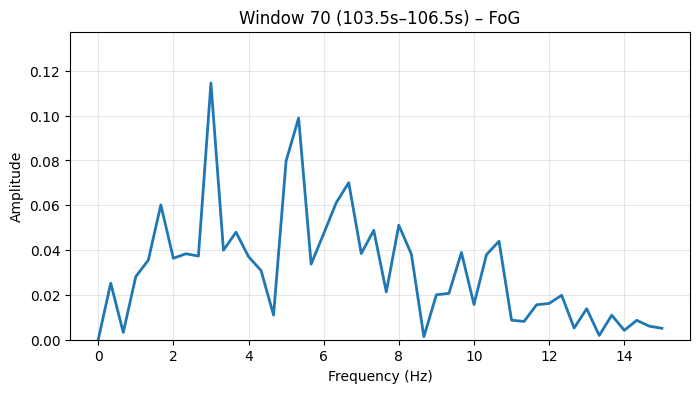

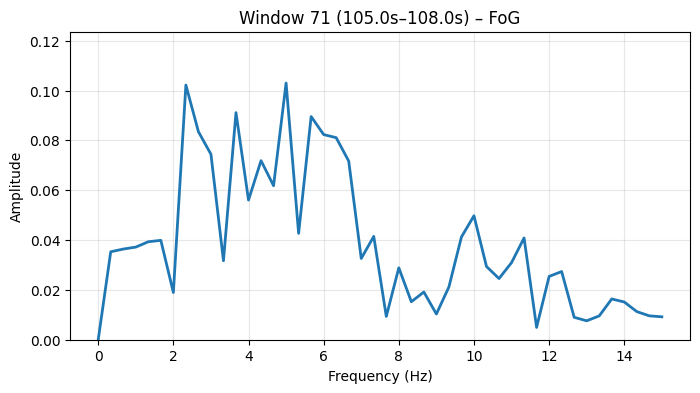

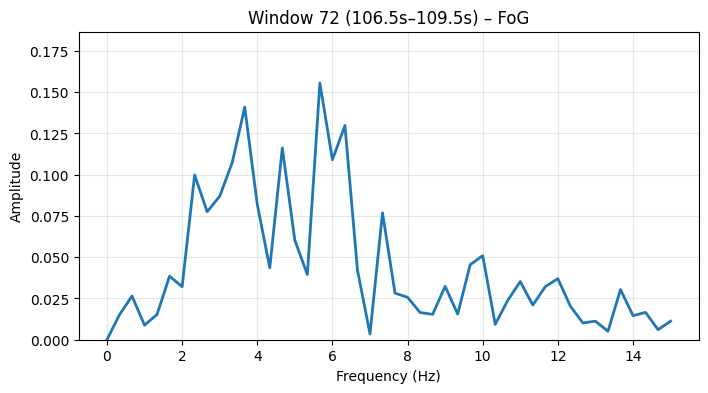

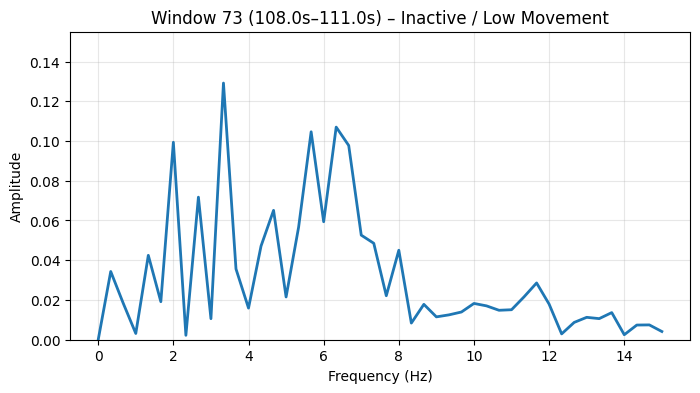

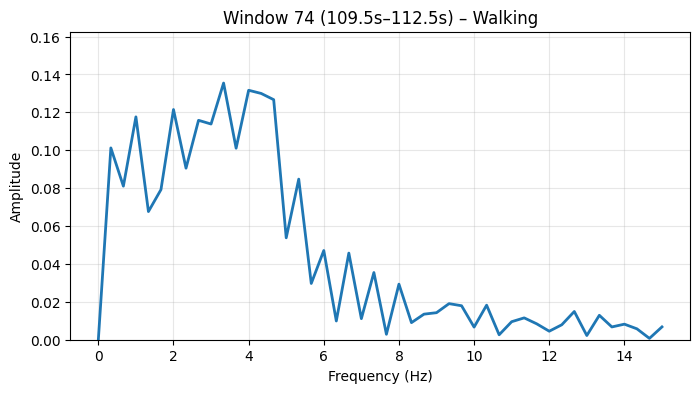

In [14]:
plot_individual_window_ffts(df_1, fs=128)

In [15]:
def plot_welch_psd(df, fs=128):
    """
    Computes a clean Power Spectral Density (PSD) plot using Welch’s method.
    Applied to the magnitude of accelerometer data.
    """

    # 1. Combine accelerometer axes
    acc = np.sqrt(df['AccV']**2 + df['AccML']**2 + df['AccAP']**2)

    # 2. Low-pass filter at 15 Hz (same as research)
    b, a = butter(2, 15/(fs/2), btype='low')
    acc_filt = filtfilt(b, a, acc)

    # 3. Welch power spectral density
    f, Pxx = welch(
        acc_filt,
        fs=fs,
        window='hann',
        nperseg=int(3 * fs),      # 3-second windows
        noverlap=int(1.5 * fs),   # 50% overlap
        detrend='constant',
        scaling='density'
    )

    # 4. Only plot 0–15 Hz
    mask = f <= 15
    f = f[mask]
    Pxx = Pxx[mask]

    # 5. Plot PSD
    plt.figure(figsize=(10, 4))
    plt.plot(f, Pxx)  # log scale for clarity
    plt.title("Welch Power Spectral Density (0–15 Hz)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (dB/Hz)")
    plt.grid(True)
    plt.show()

    return f, Pxx

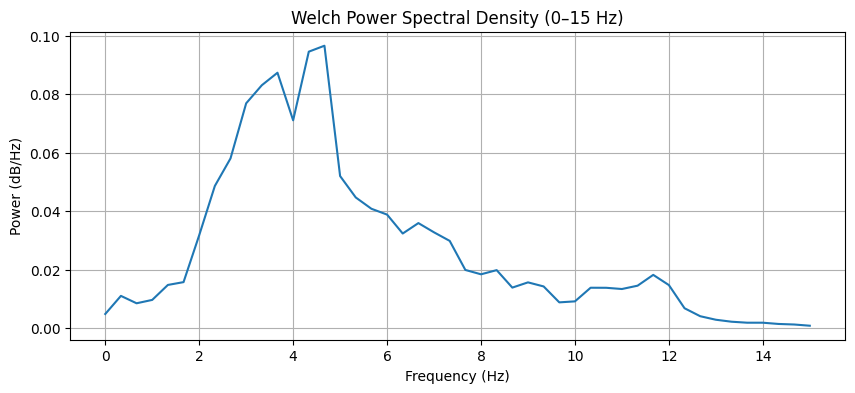

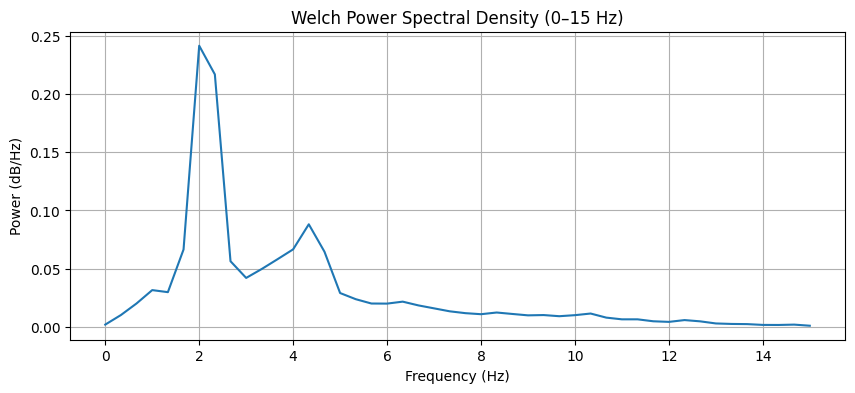

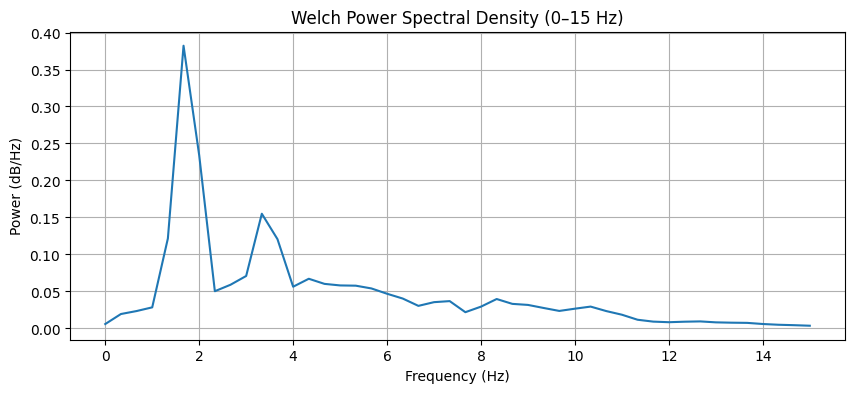

(array([ 0.        ,  0.33333333,  0.66666667,  1.        ,  1.33333333,
         1.66666667,  2.        ,  2.33333333,  2.66666667,  3.        ,
         3.33333333,  3.66666667,  4.        ,  4.33333333,  4.66666667,
         5.        ,  5.33333333,  5.66666667,  6.        ,  6.33333333,
         6.66666667,  7.        ,  7.33333333,  7.66666667,  8.        ,
         8.33333333,  8.66666667,  9.        ,  9.33333333,  9.66666667,
        10.        , 10.33333333, 10.66666667, 11.        , 11.33333333,
        11.66666667, 12.        , 12.33333333, 12.66666667, 13.        ,
        13.33333333, 13.66666667, 14.        , 14.33333333, 14.66666667,
        15.        ]),
 array([0.00589352, 0.01943016, 0.02345077, 0.02845266, 0.1216236 ,
        0.38216405, 0.23407095, 0.05025713, 0.05900061, 0.07085756,
        0.15501285, 0.12063479, 0.05633642, 0.06710415, 0.06019543,
        0.05808592, 0.05774931, 0.05401193, 0.04684126, 0.04036138,
        0.03045398, 0.03546988, 0.03688363, 0.02

In [16]:
plot_welch_psd(df_1, fs=128)
plot_welch_psd(df_2, fs=128)
plot_welch_psd(df_3, fs=128)

In [17]:
def band_power_over_time(f, t, Sxx, band):
    fmin, fmax = band
    mask = (f >= fmin) & (f <= fmax)
    # trapezoidal integration across frequency for each time slice
    bp = np.trapz(Sxx[mask, :], f[mask], axis=0)
    return t, bp

In [18]:
def plot_spectrogram(df, fs=128):
    # 1. Combine axes
    sig = np.sqrt(df['AccV']**2 + df['AccML']**2 + df['AccAP']**2)

    # 2. Remove DC drift
    sig = detrend(sig)

    # 3. Low-pass filter at 15 Hz
    b, a = butter(2, 15/(fs/2), btype='low')
    sig = filtfilt(b, a, sig)

    # 4. Normalize
    sig = (sig - np.mean(sig)) / np.std(sig)

    # 5. Compute STFT
    nperseg = int(3 * fs)       # 3-second window
    noverlap = int(2 * fs)      # 2-second overlap
    f, t, Sxx = spectrogram(sig, fs=fs, nperseg=nperseg,
                            noverlap=noverlap, window='hann')

    # 6. Limit to 0–15 Hz
    mask = f <= 15
    f = f[mask]
    Sxx = Sxx[mask, :]

    # 7. Convert to dB
    Sxx_db = 10 * np.log10(Sxx + 1e-12)

    # 8. Clip color scale to reduce noise
    vmin = np.percentile(Sxx_db, 5)
    vmax = np.percentile(Sxx_db, 95)

    # 9. Plot clean spectrogram
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(t, f, Sxx_db, shading='gouraud',
                   cmap='viridis', vmin=vmin, vmax=vmax)

    plt.title("Clean Spectrogram (0–15 Hz)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Power (dB)")
    plt.show()

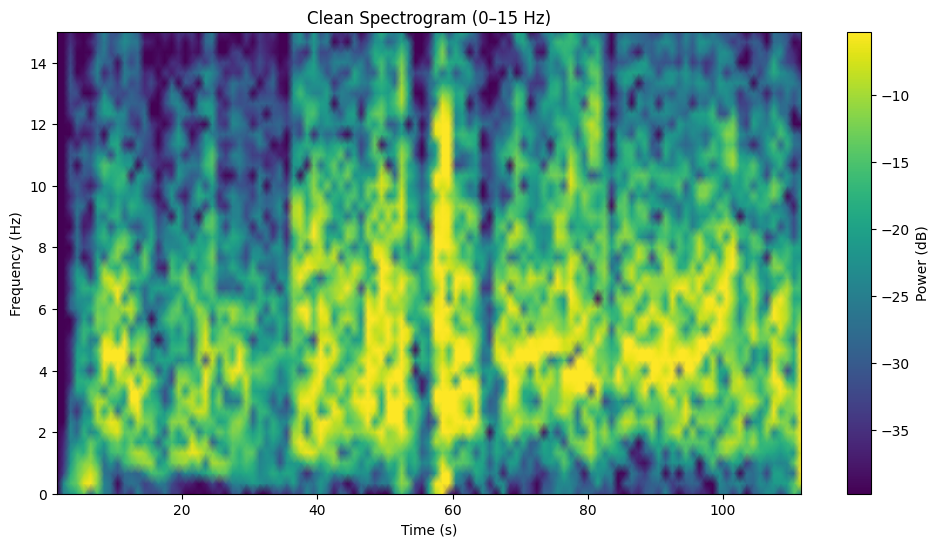

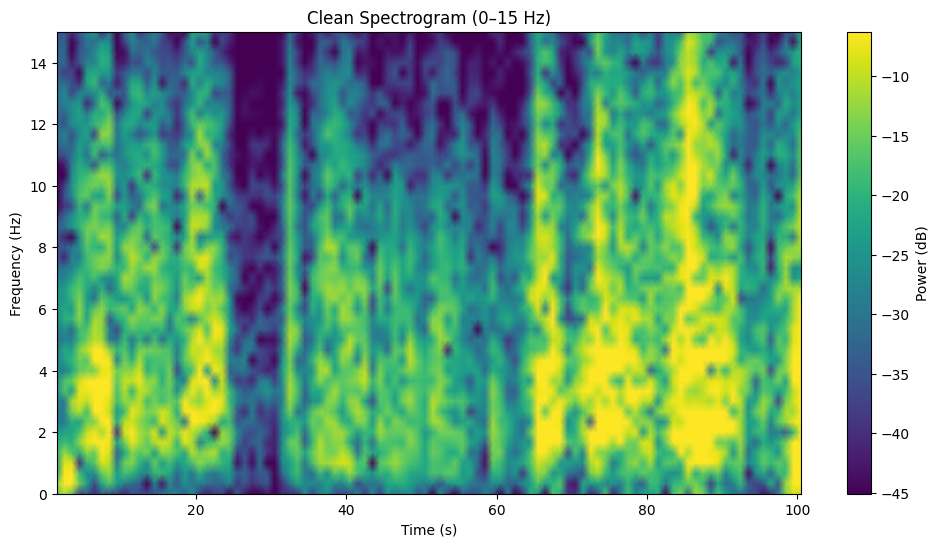

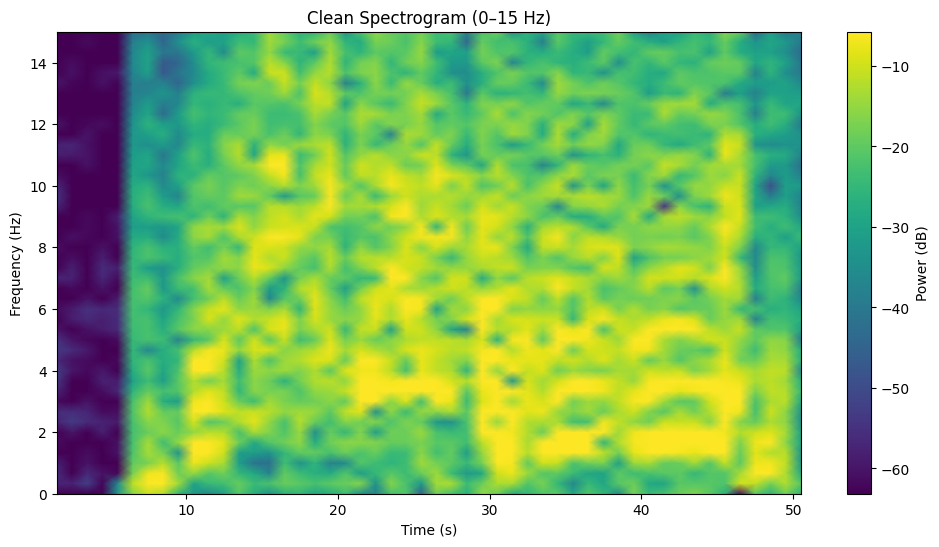

In [19]:
plot_spectrogram(df_1, fs=128)
plot_spectrogram(df_2, fs=128)
plot_spectrogram(df_3, fs=128)

In [20]:
files = glob.glob("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/*.csv")[:50]

# for f in files:
#     df = pd.read_csv(f)
#     plot_fog_events_overlay(df, title="Large Sample View")

In [21]:
# for f in files:
#     df = pd.read_csv(f)
#     plot_combined_fft(df, fs=128)

In [22]:
# for f in files:
#     df = pd.read_csv(f)
#     plot_spectrogram(df, fs=128)